<a href="https://colab.research.google.com/github/nonoumasy/los-angeles-traffic-accidents-2010-present/blob/master/LA_Traffic_Accident_2010_present.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install pandas-profiling

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopy
import pandas_profiling
import folium
from folium.plugins import HeatMap, FastMarkerCluster

In [0]:
df = pd.read_csv('https://data.lacity.org/api/views/d5tf-ez2w/rows.csv?accessType=DOWNLOAD')

In [0]:
#column cleanup
df.columns = df.columns.str.lower().str.replace('\W+', '_').str.replace('(', '').str.replace(')', '')

#keep only these columns
df = df[['date_occurred', 'time_occurred', 'area_id', 'area_name', 'mo_codes', 'victim_age', 'victim_sex', 'victim_descent', 'location']]

#replace race names using map
race_dict = {'A' : 'Other Asian',
        'B' : 'Black', 
        'C' : 'Chinese', 
        'D' : 'Cambodian', 
        'F' : 'Filipino', 
        'G' : 'Guamanian', 
        'H' : 'Hispanic/Latin',
        'I' : 'AmerIndian/Alaskan',
        'J' : 'Japanese', 
        'K' : 'Korean', 
        'L' : 'Laotian', 
        'O' : 'Other', 
        'P' : 'Pacific Islander ',
        'S' : 'Samoan', 
        'U' : 'Hawaiian',
        'V' : 'Vietnamese', 
        'W' : 'White', 
        'X' : 'Unknown', 
        'Z' : 'Asian Indian'}

df['victim_descent'] = df['victim_descent'].map(race_dict)

#convert columns to datetime series
df['date_occurred'] = df.loc[:, 'date_occurred'].apply(pd.to_datetime)

#cleanup location
df[['lat', 'lon']] = df.location.str.replace('(','').str.replace(')','').str.split(',', expand=True)
df['lat'] = pd.to_numeric(df['lat'])
df['lon'] = pd.to_numeric(df['lon'])

# #change some columns to category type
for col in df.select_dtypes(['object']):   
  df[col] = df[col].astype('category')

# add zeros to hour column
df['time_occurred']= df['time_occurred'].astype(str).str.zfill(4) + '00'

#use datetime as index
df.set_index(pd.to_datetime(df.date_occurred.astype(str) + df.time_occurred, format='%Y-%m-%d%H%M%S'), inplace=True)

#open mocodes text file and convert to list
with open('/content/mocodes.txt','r') as file:
  text = file.readlines()
text_list = pd.Series(text)

#preprocess mocodes
mo_code_num = []
mo_code_desc = []
for i in text_list: 
  mo_code_num.append(i[0:4])
  mo_code_desc.append(i[5:-1])

#make into a dict
mo_code_dict = dict(zip(mo_code_num, mo_code_desc))
#add '0000' as unknown in dict
mo_code_dict.update({'0000' : 'Unknown'})
mo_code_dict.update({'0100' : 'Suspect Impersonate'})

#delete bad value
del mo_code_dict['\ufeff010']

#convert NaNs in mo_codes as '0000'. This will be 'unknown' in the mo_code dict
df['mo_codes'] = df['mo_codes'].astype('object').fillna('0000')

#split string codes
df['mo_codes'] = df.mo_codes.str.split()

#drop columns
df.drop(['date_occurred', 'time_occurred', ], axis=1, inplace=True)


In [12]:
df.head()

,area_id,area_name,mo_codes,victim_age,victim_sex,victim_descent,location,lat,lon
2019-05-18 01:10:00,2,Rampart,"[3101, 3401, 3701, 3004, 3030]",33.0,F,Hispanic/Latin,"(34.0508, -118.2731)",34.0508,-118.2731
2011-10-11 17:35:00,5,Harbor,[0506],27.0,F,Other,"(33.8542, -118.2905)",33.8542,-118.2905
2018-08-09 18:30:00,6,Hollywood,"[3004, 3028, 3030, 3035, 3036, 3101, 3401, 370...",33.0,M,White,"(34.1052, -118.3252)",34.1052,-118.3252
2012-05-09 08:45:00,3,Southwest,[0000],51.0,M,Black,"(34.0255, -118.3548)",34.0255,-118.3548
2012-06-13 07:45:00,12,77th Street,[0605],48.0,F,Black,"(33.9997, -118.2827)",33.9997,-118.2827


EDA

In [18]:
df.shape

(515360, 9)

In [15]:
profile = pandas_profiling.ProfileReport(df, title='Pandas Profiling Report')

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,10
Number of observations,515360
Total Missing (%),1.9%
Total size in memory,28.6 MiB
Average record size in memory,58.2 B
Numeric,4
Categorical,4
Boolean,0
Date,1
Text (Unique),0
Rejected,0


In [147]:
mo_code_list_final = []
for i in range(20):
  for j in df.mo_codes.iloc[i]:
    print(i, mo_code_dict[j])

0 T/C - PCF (A) In the Narrative
0 T/C - Type of Collision 
0 T/C - Movement Preceding Collision 
0 T/C-VehvsVeh
0 T/C - Hit and Run Misd
1 Forced to masturbate suspect
2 T/C-VehvsVeh
2 T/C - (N) Non Injury
2 T/C - Hit and Run Misd
2 T/C - City Property Involved - No
2 T/C - At Intersection - Yes
2 T/C - PCF (A) In the Narrative
2 T/C - Type of Collision 
2 T/C - Movement Preceding Collision 
2 T/C- Hollywood
3 Unknown
4 Traffic Accident/Traffic related incident
5 T/C - Veh vs Parked Veh
5 T/C - (N) Non Injury
5 T/C - Hit and Run Misd
5 T/C - City Property Involved - No
5 T/C - At Intersection - No
5 T/C - PCF (A) In the Narrative
5 T/C - Type of Collision 
5 T/C - Movement Preceding Collision 
5 T/C- Hollywood
6 T/C - PCF (A) In the Narrative
6 T/C - Type of Collision 
6 T/C - Movement Preceding Collision 
6 T/C-VehvsVeh
6 T/C - (C) Complaint of Injury
6 T/C - Hit and Run Fel
6 T/C - At Intersection - Yes
7 T/C - PCF (A) In the Narrative
7 T/C - Type of Collision 
7 T/C - Movement Pre

In [0]:
#subset data to year 2019
df_2019 = df['2019']

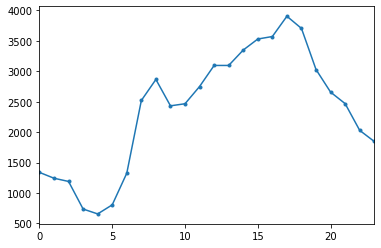

In [0]:
#traffic accidents by hour
df_2019.groupby([df_2019.index.hour])['area_name'].count().plot(marker='.')

In [0]:
#area name vs hour of day crosstab
pd.crosstab(index=df_2019.area_name, 
            columns=df_2019.index.hour,
            #margins=True,
            #normalize=True,
            ).style.background_gradient(cmap='Blues')

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
area_name,,,,,,,,,,,,,,,,,,,,,,,,
77th Street,116,113,104,66,57,76,111,175,171,130,148,168,195,229,217,226,238,289,259,246,194,189,148,125
Central,59,54,56,26,21,37,56,85,124,148,132,125,154,159,153,158,154,196,169,116,71,93,85,60
Devonshire,59,58,45,36,20,39,67,150,149,92,115,132,178,168,186,208,175,209,155,142,132,107,96,69
Foothill,53,63,51,32,24,32,69,106,79,92,63,90,90,92,105,109,126,115,101,103,111,90,92,80
Harbor,43,46,44,38,31,38,54,101,113,70,90,107,118,122,102,112,117,123,124,121,110,102,84,65
Hollenbeck,50,44,57,33,28,43,57,106,123,92,87,86,71,87,115,116,127,133,111,114,84,65,62,74
Hollywood,76,86,86,44,29,28,40,74,122,109,122,141,144,129,151,154,156,195,181,139,126,100,96,134
Mission,73,63,58,44,31,38,67,150,102,85,89,104,125,126,136,139,157,170,157,144,136,110,94,87
N Hollywood,85,65,70,40,29,38,65,128,140,109,114,137,157,161,165,188,162,185,193,128,147,150,119,114


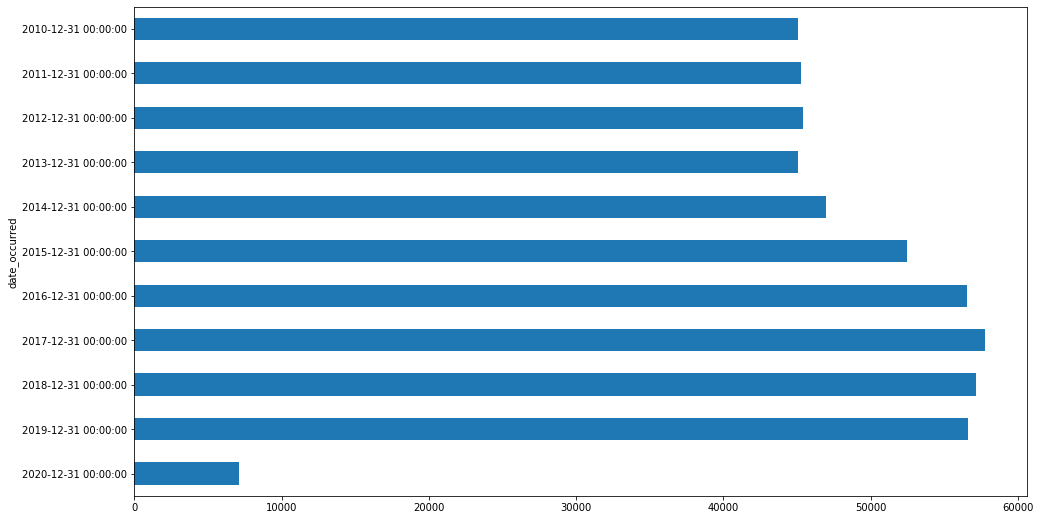

In [0]:
#traffic accidents by year
df.resample('Y')['time_occurred'].count()[::-1].plot(kind='barh', figsize=(16,9))

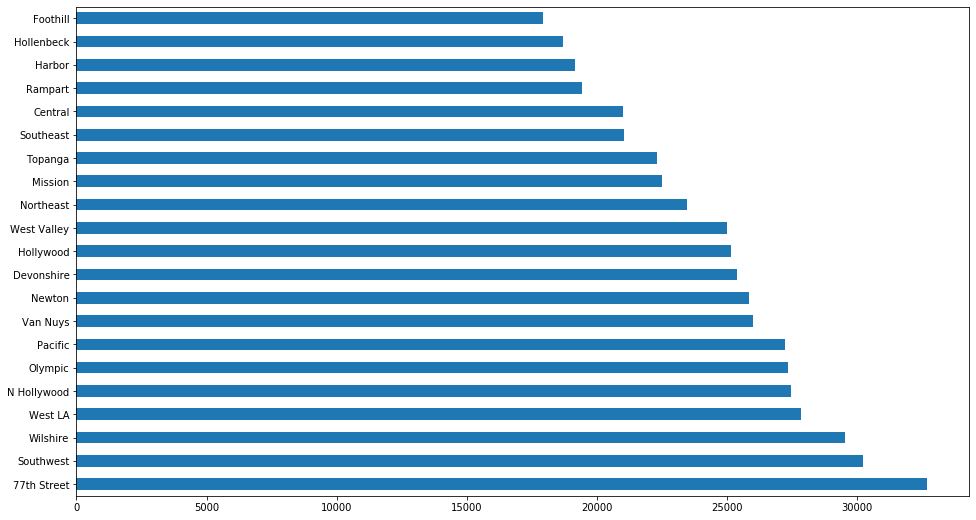

In [0]:
#traffic accidents by area_name
df.area_name.value_counts().plot(kind='barh', figsize=(16,9))

In [0]:
#traffic accidents victims
df.victim_sex.value_counts(normalize=True)

M    0.590908
F    0.383951
X    0.024843
H    0.000276
N    0.000022
Name: victim_sex, dtype: float64

In [0]:
#traffic accidents by premises
df.premise_description.value_counts(normalize=True)[:5]#.plot(kind='barh', figsize=(12,20))

STREET         0.954342
PARKING LOT    0.031964
SIDEWALK       0.004931
ALLEY          0.001710
DRIVEWAY       0.001657
Name: premise_description, dtype: float64

In [0]:
#traffic accident victims by race
df.victim_descent.value_counts()

Hispanic/Latin        190175
White                 121873
Other                  75633
Black                  67421
Unknown                24396
Other Asian            19261
Korean                  4093
Filipino                1545
Chinese                  772
Hawaiian                 356
Japanese                 302
Vietnamese               204
Pacific Islander         192
AmerIndian/Alaskan       157
Asian Indian             139
Guamanian                 39
Samoan                    32
Cambodian                 17
Laotian                    5
Name: victim_descent, dtype: int64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


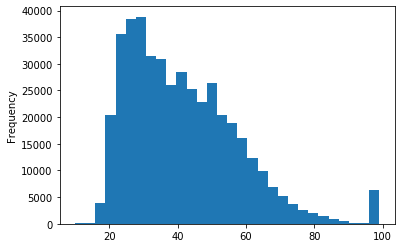

In [0]:
#traffic accident victims by age
df.victim_age.plot('hist', bins=30)

In [0]:
loc_list = list(zip(df.lat.tolist(), df.lon.tolist()))

In [172]:
loc_list

[(34.0508, -118.2731),
 (33.8542, -118.2905),
 (34.1052, -118.3252),
 (34.0255, -118.3548),
 (33.9997, -118.2827),
 (34.1016, -118.3387),
 (34.0559, -118.2584),
 (34.0549, -118.2778),
 (34.0818, -118.2917),
 (34.049, -118.197),
 (34.098, -118.3252),
 (34.0962, -118.3295),
 (34.0711, -118.3764),
 (34.0462, -118.2628),
 (34.0459, -118.2579),
 (33.7896, -118.2415),
 (34.0748, -118.2317),
 (34.0492, -118.2742),
 (34.0835, -118.2838),
 (34.0613, -118.428),
 (34.0328, -118.44200000000001),
 (34.0351, -118.3779),
 (34.0561, -118.5512),
 (34.0822, -118.4349),
 (34.1307, -118.4432),
 (34.0439, -118.4317),
 (34.043, -118.4819),
 (34.0378, -118.4333),
 (34.046, -118.4652),
 (34.0461, -118.5242),
 (34.0498, -118.3801),
 (34.035, -118.4002),
 (34.0461, -118.3988),
 (34.1939, -118.4618),
 (34.1613, -118.429),
 (34.1794, -118.4488),
 (34.2011, -118.5273),
 (34.1576, -118.4138),
 (34.0312, -118.3852),
 (34.0548, -118.3837),
 (34.2143, -118.5534),
 (34.1715, -118.5428),
 (34.0939, -118.2412),
 (33.96, 

In [1]:
loc = geopy.geocoders.Nominatim(user_agent='me').geocode('los angeles, ca')

m = folium.Map(location=(loc.latitude, loc.longitude),
               zoom_start=10,
               min_zoom=9,
               tiles='cartodbpositron')

loc_list = df_2019[['lat', 'lon']].values.tolist()

FastMarkerCluster(loc_list).add_to(m)

HeatMap(loc_list,
        radius=10,
        blur=10,
        ).add_to(m)

m

NameError: ignored

In [4]:
import pandas as pd

codes = {0:'Test1',1:'test 2',2:'test 3',3:'test 4'}
df1 = pd.DataFrame([["red",[0,1,2],5],["blue",[3,1],6]],columns=[0,'codes',2])

# first explode the list into its own rows
df2 = df1['codes'].apply(pd.Series).stack().astype(int).reset_index(level=1, drop=True).to_frame('codes').join(df1[[0,2]])

#now use map to apply the text descriptions
df2['desc'] = df2['codes'].map(codes)

print(df2)


   codes     0  2    desc
0      0   red  5   Test1
0      1   red  5  test 2
0      2   red  5  test 3
1      3  blue  6  test 4
1      1  blue  6  test 2


In [5]:
df1

,0,codes,2
0,red,"[0, 1, 2]",5
1,blue,"[3, 1]",6


In [6]:
df2

,codes,0,2,desc
0,0,red,5,Test1
0,1,red,5,test 2
0,2,red,5,test 3
1,3,blue,6,test 4
1,1,blue,6,test 2
